<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-data" data-toc-modified-id="Read-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read data</a></span><ul class="toc-item"><li><span><a href="#翻訳" data-toc-modified-id="翻訳-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>翻訳</a></span></li></ul></li><li><span><a href="#初期データでの性能チェック" data-toc-modified-id="初期データでの性能チェック-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>初期データでの性能チェック</a></span><ul class="toc-item"><li><span><a href="#データ準備" data-toc-modified-id="データ準備-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>データ準備</a></span></li><li><span><a href="#モデル学習" data-toc-modified-id="モデル学習-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>モデル学習</a></span></li></ul></li><li><span><a href="#Profile" data-toc-modified-id="Profile-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Profile</a></span><ul class="toc-item"><li><span><a href="#train" data-toc-modified-id="train-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>train</a></span><ul class="toc-item"><li><span><a href="#外れ値除去" data-toc-modified-id="外れ値除去-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>外れ値除去</a></span><ul class="toc-item"><li><span><a href="#item_price" data-toc-modified-id="item_price-3.1.1.1"><span class="toc-item-num">3.1.1.1&nbsp;&nbsp;</span>item_price</a></span></li><li><span><a href="#item_cnt_day" data-toc-modified-id="item_cnt_day-3.1.1.2"><span class="toc-item-num">3.1.1.2&nbsp;&nbsp;</span>item_cnt_day</a></span></li><li><span><a href="#date" data-toc-modified-id="date-3.1.1.3"><span class="toc-item-num">3.1.1.3&nbsp;&nbsp;</span>date</a></span></li><li><span><a href="#item_price" data-toc-modified-id="item_price-3.1.1.4"><span class="toc-item-num">3.1.1.4&nbsp;&nbsp;</span>item_price</a></span></li></ul></li></ul></li><li><span><a href="#items" data-toc-modified-id="items-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>items</a></span></li><li><span><a href="#shops" data-toc-modified-id="shops-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>shops</a></span></li><li><span><a href="#item_cat" data-toc-modified-id="item_cat-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>item_cat</a></span></li></ul></li><li><span><a href="#予測" data-toc-modified-id="予測-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>予測</a></span><ul class="toc-item"><li><span><a href="#trainデータ" data-toc-modified-id="trainデータ-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>trainデータ</a></span></li><li><span><a href="#testデータ" data-toc-modified-id="testデータ-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>testデータ</a></span></li><li><span><a href="#予測" data-toc-modified-id="予測-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>予測</a></span></li><li><span><a href="#xgboost" data-toc-modified-id="xgboost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>xgboost</a></span></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path
from tqdm.autonotebook import tqdm
import pandas_profiling as pd_pro
import cufflinks as cf; cf.go_offline()
from googletrans import Translator
from copy import deepcopy as copy
import datetime
import math

/home/sumito/.local/share/virtualenvs/work-xfIEOHhD/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


https://www.kaggle.com/c/competitive-data-science-predict-future-sales

2013/1 ~ 2015/10までの学習データを使って2015/11の店毎/アイテム毎の月の販売数を予測する

# Read data

In [3]:
filelist = list(Path("data").glob("*.csv"))
filelist

[PosixPath('data/shops.csv'),
 PosixPath('data/item_categories.csv'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/items.csv'),
 PosixPath('data/test.csv'),
 PosixPath('data/sales_train.csv')]

**File descriptions**
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

**Data fields**
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

[Data](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)

In [4]:
data = {
    "train": pd.read_csv("data/sales_train.csv", parse_dates=[0]),
    "test": pd.read_csv("data/test.csv"),
    "shops": pd.read_csv("data/shops.csv"),
    "items": pd.read_csv("data/items.csv"),
    "item_cat": pd.read_csv("data/item_categories.csv"),
    "sample": pd.read_csv("data/sample_submission.csv")
}

In [6]:
for key in data.keys():
    print(key)
    display(data[key].head())

train


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


test


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


shops


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


items


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


item_cat


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


sample


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## 翻訳

In [5]:
s = data["item_cat"]["item_category_name"][0]
s

'PC - Гарнитуры/Наушники'

In [6]:
translator = Translator()
result = translator.translate(s, dest="ja")

In [7]:
result.__dict__["text"]

'PC  - ヘッドセット/ヘッドフォン'

In [10]:
def translate_to_ja(s):
    translator = Translator()
    result = translator.translate(s, dest="ja")
    return result.__dict__["text"]

In [11]:
tqdm.pandas(desc="translate")
data["item_cat"]["item_category_name_ja"] = data["item_cat"]["item_category_name"].progress_apply(translate_to_ja)
data["item_cat"].head()

,item_category_name,item_category_id,item_category_name_ja
0,PC - Гарнитуры/Наушники,0,PC - ヘッドセット/ヘッドフォン
1,Аксессуары - PS2,1,アクセサリー - PS2
2,Аксессуары - PS3,2,アクセサリー - PS3
3,Аксессуары - PS4,3,アクセサリー - PS4
4,Аксессуары - PSP,4,アクセサリ - PSP


In [10]:
data["item_cat"]["item_category_name_ja"].unique()

array(['PC  - ヘッドセット/ヘッドフォン', 'アクセサリー -  PS2', 'アクセサリー -  PS3',
       'アクセサリー -  PS4', 'アクセサリ -  PSP', 'アクセサリー -  PSVITA',
       'アクセサリー -  XBOX 360', 'アクセサリー -  XBOX ONE', 'チケット（桁）', '納品',
       'ゲーム機 -  PS2', 'ゲームコンソール -  PS3', 'ゲーム機 -  PS4', 'ゲーム機 -  PSP',
       'ゲーム機 -  PSVITA', 'ゲーム機 -  XBOX 360', 'ゲーム機 -  XBOX ONE',
       'ゲーム機 - その他', 'ゲーム -  PS2', 'ゲーム -  PS3', 'ゲーム -  PS4',
       'ゲーム -  PSP', 'ゲーム -  PSVITA', 'ゲーム -  XBOX 360',
       'ゲーム -  XBOX ONE', 'ゲーム - ゲームのためのアクセサリー', 'ゲームアンドロイド - デジタル',
       'ゲームMAC  - デジタル', 'ゲームPC  - 追加の出版物', 'ゲームPC  - コレクターズ・エディション',
       'ゲームPC  - スタンダード版', 'ゲームPC  - デジタル', '支払カード（ビデオ、音楽、ゲーム）',
       '支払カード - ライブ！', '支払カード - ライブ！ （デジタル）', '支払カード -  PSN',
       '支払カード -  Windowsの（フィギュア）', '作品 - ブルーレイ', '作品 - ブルーレイ3D',
       'ムービー - ブルーレイ4K', 'ムービー -  DVD', 'シネマ - コレクタ', '書籍 - アートブック、百科事典',
       '書籍 - オーディオブック', '書籍 - オーディオブック（フィギュア）', '書籍 - オーディオブック1C',
       '書籍 - ビジネスブックス', '書籍 - コミック、マンガ', '書籍 - コンピュータブックス',
       '書籍 - 系統的材料1C

# 初期データでの性能チェック

## データ準備

In [7]:
train = copy(data["train"])
train = train.set_index("date")
# train["year"] = train["date"].apply(lambda x: x.year)
# train["month"] = train["date"].apply(lambda x: x.month)
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-02-01,0,59,22154,999.00,1.0
2013-03-01,0,25,2552,899.00,1.0
2013-05-01,0,25,2552,899.00,-1.0
2013-06-01,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0


In [8]:
train_gb = train.groupby([train.index.year, train.index.month, "item_id", "shop_id"])["item_cnt_day"].sum()
train_gb.index.names = ["year", "month", "item_id", "shop_id"]
train_gb = train_gb.reset_index().rename(columns={"item_cnt_day": "item_cnt_month"})
train_gb

,year,month,item_id,shop_id,item_cnt_month
0,2013,1,27,5,1.0
1,2013,1,27,10,1.0
2,2013,1,27,31,1.0
3,2013,1,28,15,1.0
4,2013,1,28,19,2.0
...,...,...,...,...,...
1799390,2015,12,22167,25,1.0
1799391,2015,12,22167,27,1.0
1799392,2015,12,22167,31,1.0
1799393,2015,12,22167,42,1.0


In [9]:
test = copy(data["test"])
test.insert(loc=1, column="month", value=11)
test.insert(loc=1, column="year", value=2015)
test = test.drop("ID", axis=1)
test

,year,month,shop_id,item_id
0,2015,11,5,5037
1,2015,11,5,5320
2,2015,11,5,5233
3,2015,11,5,5232
4,2015,11,5,5268
...,...,...,...,...
214195,2015,11,45,18454
214196,2015,11,45,16188
214197,2015,11,45,15757
214198,2015,11,45,19648


## モデル学習

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [11]:
target_col = "item_cnt_month"
learn_col = list(train_gb.columns)
learn_col.remove(target_col)
print(target_col, "←", learn_col)

item_cnt_month ← ['year', 'month', 'item_id', 'shop_id']


In [18]:
train_x, train_y = train_gb[learn_col], train_gb[target_col]
mms = MinMaxScaler()
train_x = pd.DataFrame(mms.fit_transform(train_x), columns=train_x.columns)
train_x.head()

,year,month,item_id,shop_id
0,0.0,0.0,0.001218,0.084746
1,0.0,0.0,0.001218,0.169492
2,0.0,0.0,0.001218,0.525424
3,0.0,0.0,0.001263,0.254237
4,0.0,0.0,0.001263,0.322034


In [20]:
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
test2 = mms.transform(test)
predict = pd.Series(lr.predict(test2))
test["item_cnt_month"] = predict
# test = pd.DataFrame(mms.inverse_transform(test), columns=test.columns)
test

,year,month,shop_id,item_id,item_cnt_month
0,2015,11,5,5037,5.729836
1,2015,11,5,5320,5.928951
2,2015,11,5,5233,5.867739
3,2015,11,5,5232,5.867035
4,2015,11,5,5268,5.892364
...,...,...,...,...,...
214195,2015,11,45,18454,15.169438
214196,2015,11,45,16188,13.575108
214197,2015,11,45,15757,13.271862
214198,2015,11,45,19648,16.009522


In [46]:
submission = copy(test["item_cnt_month"])
submission = submission.reset_index()
submission.rename(columns={"index": "ID"}, inplace=True)
now = lambda :datetime.datetime.now().strftime("%Y%m%d%H%M%S")
submission.to_csv(f"results/{now()}.csv", index=False)

# Profile
## train

In [ ]:
profile = pd_pro.ProfileReport(data["train"])
profile.to_file("profile/train_profile.html")

[train_profile](profile/train_profile.html)

### 外れ値除去
#### item_price

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

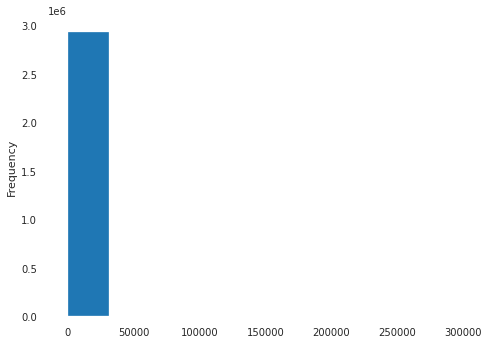

In [12]:
train = copy(data["train"])
train["item_price"].plot(kind="hist")
train["item_price"].describe()

count    2.788632e+06
mean     6.408760e+02
std      5.958757e+02
min     -1.000000e+00
25%      2.480000e+02
50%      3.990000e+02
75%      8.490000e+02
max      2.689900e+03
Name: item_price, dtype: float64

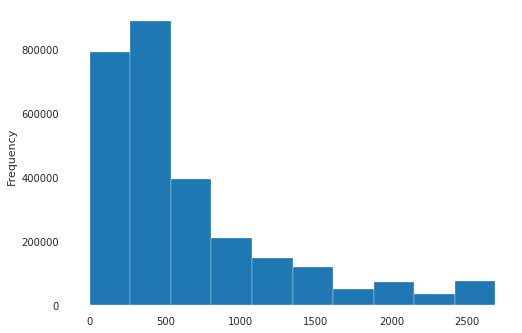

In [13]:
quant = train["item_price"].quantile(0.95)
train = train[train["item_price"] < quant]
train["item_price"].plot(kind="hist")
train["item_price"].describe()

#### item_cnt_day

count    2.788632e+06
mean     1.233619e+00
std      2.611853e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

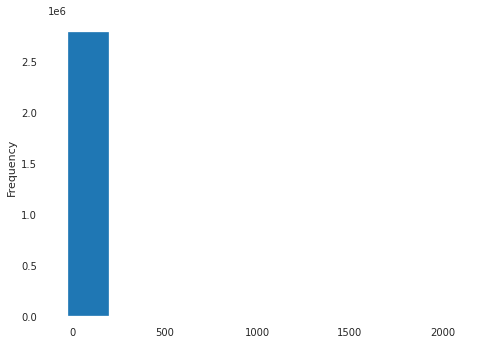

In [14]:
train["item_cnt_day"].plot(kind="hist")
train["item_cnt_day"].describe()

In [15]:
train["item_cnt_day"].nlargest(10)

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
2626181     539.0
2851073     533.0
2048518     512.0
2067669     508.0
2864260     504.0
Name: item_cnt_day, dtype: float64

In [16]:
train = train[train["item_cnt_day"] < 500]

#### date

In [17]:
train["year"] = train["date"].apply(lambda x: x.year)
train["month"] = train["date"].apply(lambda x: x.month)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,2013-02-01,0,59,22154,999.00,1.0,2013,2
1,2013-03-01,0,25,2552,899.00,1.0,2013,3
2,2013-05-01,0,25,2552,899.00,-1.0,2013,5
3,2013-06-01,0,25,2554,1709.05,1.0,2013,6
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1


In [19]:
def month2real(month):
    deg = (360/12) * (month-3)
    return math.cos(deg)

def month2imag(month):
    deg = (360/12) * (month-3)
    return math.sin(deg)

In [20]:
deg = pd.DataFrame([range(1, 13)], index=["month"]).T
deg["deg"] = deg["month"].apply(lambda x: (360/12)*(x-3))
deg["real"] = deg["deg"].apply(month2real)
deg["imag"] = deg["deg"].apply(month2imag)
deg

,month,deg,real,imag
0,1,-60.0,0.325952,0.945386
1,2,-30.0,-0.921716,0.387865
2,3,0.0,-0.448074,-0.893997
3,4,30.0,0.862349,-0.506314
4,5,60.0,0.562329,0.826913
5,6,90.0,-0.787844,0.615874
6,7,120.0,-0.666713,-0.745314
7,8,150.0,0.699509,-0.714623
8,9,180.0,0.759394,0.650631
9,10,210.0,-0.598895,0.800828


#### item_price

In [21]:
item_price = train.groupby(["shop_id", "item_id"])["item_price"].mean()
item_price.head()

shop_id  item_id
0        30         265.0
         31         434.0
         32         221.0
         33         347.0
         35         247.0
Name: item_price, dtype: float64

In [22]:
data["train2"] = copy(train)

## items

In [23]:
data["items"].head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


## shops

In [40]:
data["shops"].head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


## item_cat

In [42]:
data["item_cat"].head()

,item_category_name,item_category_id,item_category_name_ja
0,PC - Гарнитуры/Наушники,0,PC - ヘッドセット/ヘッドフォン
1,Аксессуары - PS2,1,アクセサリー - PS2
2,Аксессуары - PS3,2,アクセサリー - PS3
3,Аксессуары - PS4,3,アクセサリー - PS4
4,Аксессуары - PSP,4,アクセサリ - PSP


# 予測
## trainデータ

In [25]:
train_gb = data["train2"].groupby(["year", "month", "item_id", "shop_id"])["item_cnt_day"].sum()
train_gb.index.names = ["year", "month", "item_id", "shop_id"]
train_gb = train_gb.reset_index().rename(columns={"item_cnt_day": "item_cnt_month"})
train_gb = train_gb.merge(item_price, on=["item_id", "shop_id"])
items = copy(data["items"]).drop("item_name", axis=1)
train_gb = train_gb.merge(items, on="item_id")
train_gb["real"] = train_gb["month"].apply(month2real)
train_gb["imag"] = train_gb["month"].apply(month2imag)
train_gb = train_gb.drop("month", axis=1)
train_gb

,year,item_id,shop_id,item_cnt_month,item_price,item_category_id,real,imag
0,2013,27,5,1.0,848.0,19,-0.952413,0.304811
1,2014,27,5,1.0,848.0,19,-0.448074,0.893997
2,2013,27,10,1.0,1496.5,19,-0.952413,0.304811
3,2013,27,10,1.0,1496.5,19,-0.883877,0.467719
4,2013,27,31,1.0,2499.0,19,-0.952413,0.304811
...,...,...,...,...,...,...,...,...
1722660,2015,3040,55,1.0,1498.0,31,0.984382,-0.176046
1722661,2015,7151,22,1.0,58.0,30,0.984382,-0.176046
1722662,2015,9823,37,1.0,1549.0,58,0.984382,-0.176046
1722663,2015,16066,25,1.0,248.0,64,0.984382,-0.176046


## testデータ

In [57]:
test = copy(data["test"])
test.insert(loc=1, column="month", value=11)
test.insert(loc=1, column="year", value=2015)
test = test.drop("ID", axis=1)
test = test.merge(items, on="item_id", how="left").merge(item_price, on=["item_id", "shop_id"], how="left")
test["real"] = test["month"].apply(month2real)
test["imag"] = test["month"].apply(month2imag)
test = test.drop("month", axis=1)
test

,year,shop_id,item_id,item_category_id,item_price,real,imag
0,2015,5,5037,19,1633.692308,0.325781,0.945445
1,2015,5,5320,55,NaN,0.325781,0.945445
2,2015,5,5233,19,865.666667,0.325781,0.945445
3,2015,5,5232,23,599.000000,0.325781,0.945445
4,2015,5,5268,20,NaN,0.325781,0.945445
...,...,...,...,...,...,...,...
214195,2015,45,18454,55,187.888889,0.325781,0.945445
214196,2015,45,16188,64,NaN,0.325781,0.945445
214197,2015,45,15757,55,199.000000,0.325781,0.945445
214198,2015,45,19648,40,NaN,0.325781,0.945445


In [27]:
item_cat = item_price.reset_index().merge(data["items"], on="item_id").merge(data["item_cat"], on="item_category_id")[["item_price", "item_category_id"]]
item_cat

,item_price,item_category_id
0,265.000000,40
1,265.000000,40
2,274.000000,40
3,324.263158,40
4,399.000000,40
...,...,...
408180,1000.000000,36
408181,2000.000000,36
408182,250.000000,36
408183,2500.000000,36


In [82]:
def fill_item_price(data):
    mean = data["item_price"].mean()
    cat_id = data["item_category_id"].unique()[0]
    if math.isnan(mean):
        mean = item_cat.query(f"item_category_id=={cat_id}")["item_price"].mean()
    data["item_price"] = data["item_price"].fillna(mean)
    return data

# test["item_price"] = test.groupby("item_category_id")["item_price"].apply(lambda x: x.fillna(x.mean()))
test = test.groupby("item_category_id").apply(fill_item_price)
test

,year,shop_id,item_id,item_category_id,item_price,real,imag
0,2015,5,5037,19,1633.692308,0.325781,0.945445
1,2015,5,5320,55,303.320126,0.325781,0.945445
2,2015,5,5233,19,865.666667,0.325781,0.945445
3,2015,5,5232,23,599.000000,0.325781,0.945445
4,2015,5,5268,20,1821.815254,0.325781,0.945445
...,...,...,...,...,...,...,...
214195,2015,45,18454,55,187.888889,0.325781,0.945445
214196,2015,45,16188,64,1084.449333,0.325781,0.945445
214197,2015,45,15757,55,199.000000,0.325781,0.945445
214198,2015,45,19648,40,253.039219,0.325781,0.945445


## 予測

In [84]:
target_col = "item_cnt_month"
learn_col = list(train_gb.columns)
learn_col.remove(target_col)
print(target_col, "←", learn_col)

item_cnt_month ← ['year', 'item_id', 'shop_id', 'item_price', 'item_category_id', 'real', 'imag']


In [85]:
train_x, train_y = train_gb[learn_col], train_gb[target_col]
mms = MinMaxScaler()
train_x = pd.DataFrame(mms.fit_transform(train_x), columns=train_x.columns)
train_x.head()

,year,item_id,shop_id,item_price,item_category_id,real,imag
0,0.0,0.001218,0.084746,0.315230,0.228916,0.000000,0.654251
1,0.5,0.001218,0.084746,0.315230,0.228916,0.258316,0.952413
2,0.0,0.001218,0.169492,0.556326,0.228916,0.000000,0.654251
3,0.0,0.001218,0.169492,0.556326,0.228916,0.035103,0.736692
4,0.0,0.001218,0.525424,0.929028,0.228916,0.000000,0.654251


In [86]:
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [87]:
test2 = mms.transform(test)
predict = pd.Series(lr.predict(test2))
test["item_cnt_month"] = predict
# test = pd.DataFrame(mms.inverse_transform(test), columns=test.columns)
test

,year,shop_id,item_id,item_category_id,item_price,real,imag,item_cnt_month
0,2015,5,5037,19,1633.692308,0.325781,0.945445,13.719196
1,2015,5,5320,55,303.320126,0.325781,0.945445,11.552512
2,2015,5,5233,19,865.666667,0.325781,0.945445,12.519115
3,2015,5,5232,23,599.000000,0.325781,0.945445,11.981202
4,2015,5,5268,20,1821.815254,0.325781,0.945445,14.508915
...,...,...,...,...,...,...,...,...
214195,2015,45,18454,55,187.888889,0.325781,0.945445,34.641143
214196,2015,45,16188,64,1084.449333,0.325781,0.945445,32.427835
214197,2015,45,15757,55,199.000000,0.325781,0.945445,29.874624
214198,2015,45,19648,40,253.039219,0.325781,0.945445,36.887405


In [88]:
submission = copy(test["item_cnt_month"])
submission = submission.reset_index()
submission.rename(columns={"index": "ID"}, inplace=True)
now = lambda :datetime.datetime.now().strftime("%Y%m%d%H%M%S")
submission.to_csv(f"results/{now()}.csv", index=False)

## xgboost

In [90]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [97]:
reg = xgb.XGBRegressor()
hp = {
    'max_depth': [x for x in range(1, 5)], 
    'min_child_weight': [x for x in range(1, 5)],
    'n_estimators': [x for x in range(10, 100, 20)],
    'eval_metric': ['rmse'],
#     'nthread': [8],
    'objective': ['reg:squarederror'],
    'tree_method': ['gpu_hist']
}

In [98]:
reg_cv = GridSearchCV(reg, hp, cv=5)
train_x, train_y = train_gb[learn_col], train_gb[target_col]
reg_cv.fit(train_x, train_y)
print(reg_cv.best_params_, reg_cv.best_score_)

{'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 10, 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist'} -0.02078850040571596


In [99]:
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=0, importance_type='gain',
             interaction_constraints=None, learning_rate=0.300000012,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=False, verbosity=None)

In [105]:
predict = pd.Series(reg.predict(test[learn_col]))
test["item_cnt_month"] = predict
# test = pd.DataFrame(mms.inverse_transform(test), columns=test.columns)
test

,year,shop_id,item_id,item_category_id,item_price,real,imag,item_cnt_month
0,2015,5,5037,19,1633.692308,0.325781,0.945445,2.273589
1,2015,5,5320,55,303.320126,0.325781,0.945445,1.621664
2,2015,5,5233,19,865.666667,0.325781,0.945445,2.273589
3,2015,5,5232,23,599.000000,0.325781,0.945445,2.273589
4,2015,5,5268,20,1821.815254,0.325781,0.945445,2.273589
...,...,...,...,...,...,...,...,...
214195,2015,45,18454,55,187.888889,0.325781,0.945445,1.482062
214196,2015,45,16188,64,1084.449333,0.325781,0.945445,1.621664
214197,2015,45,15757,55,199.000000,0.325781,0.945445,1.482062
214198,2015,45,19648,40,253.039219,0.325781,0.945445,1.482062


In [106]:
submission = copy(test["item_cnt_month"])
submission = submission.reset_index()
submission.rename(columns={"index": "ID"}, inplace=True)
now = lambda :datetime.datetime.now().strftime("%Y%m%d%H%M%S")
submission.to_csv(f"results/{now()}.csv", index=False)